In [1]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import loguniform
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix,
    PrecisionRecallDisplay, roc_curve, roc_auc_score
)
from sklearn.model_selection import (
    cross_validate, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)
from sklearn.model_selection import cross_val_predict
import shap

In [2]:
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [4]:
# Read Data
train_df = pd.read_csv("../data/clean/clean_train.csv")
test_df = pd.read_csv("../data/clean/clean_test.csv")


# Transform native_country into binary
train_df['native_country'] = train_df['native_country'] == 'United-States'
test_df['native_country'] = test_df['native_country'] == 'United-States'

# Set positive label to ">50K", which is the class with smaller proportion
train_df['income'] = train_df['income'] == '>50K'
test_df['income'] = test_df['income'] == '>50K'

In [5]:
# Split data into features & target
X_train = train_df.drop("income", axis=1)
y_train = train_df['income']
X_test = test_df.drop("income", axis=1)
y_test = test_df['income']

In [11]:
# Preprocessing
numeric_feats = ['age', 'fnlwgt', 'hours_per_week']
categorical_null_feats = ['workclass', "occupation"]
categorical_nonull_feats = ["marital_status", "relationship"]

binary_feats = ['sex', 'native_country']
passthrough_feats = ['education_num']
drop_feats = ['education', 'race', 'capital_gain', 'capital_loss']

col_trans = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(sparse=False, handle_unknown='ignore', drop=[np.nan] * 2), categorical_null_feats),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_nonull_feats),
    (OneHotEncoder(drop='if_binary'), binary_feats),
    # ('passthrough', passthrough_feats),
    ('drop', drop_feats)
)

In [12]:
col_trans.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fnlwgt', 'hours_per_week']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop=[nan, nan],
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['workclass', 'occupation']),
                                ('onehotencoder-2',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['marital_status', 'relationship']),
                                ('onehotencoder-3',
                                 OneHotEncoder(drop='if_binary'),
                                 ['sex', 'native_country']),
                                ('drop', 'drop',
                                 ['education', 'race', 'capital

In [13]:
feature_names = (
    numeric_feats + list(col_trans.named_transformers_['onehotencoder-1'].get_feature_names_out()) 
    + list(col_trans.named_transformers_['onehotencoder-2'].get_feature_names_out()) 
    + list(col_trans.named_transformers_['onehotencoder-3'].get_feature_names_out())
   
)

In [14]:
x_trans=col_trans.transform(X_train)

In [15]:
X_train_enc = pd.DataFrame(
    data=col_trans.transform(X_train),
    columns=feature_names
)
X_train_enc.head()

,age,fnlwgt,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,marital_status_Separated,marital_status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,sex_Male,native_country_True
0,0.030671,-1.063611,-0.035429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.837109,-1.008707,-2.222153,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.042642,0.245079,-0.035429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.057047,0.425801,-0.035429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,-0.775768,1.408176,-0.035429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
# Calculate Baseline Performances
scoring = ['accuracy', 'precision', 'recall', 'f1']
results = {}
pipe_dummy = make_pipeline(
    col_trans,
    DummyClassifier()
)
results['DummyClassifier'] = pd.DataFrame(cross_validate(pipe_dummy, X_train, y_train, scoring=scoring)).mean()

# Calculate Baseline Perfromance for Random Forest Classifier
pipe_forest = make_pipeline(
    col_trans,
    RandomForestClassifier(random_state=522)
)
results['RandomForest_default'] = pd.DataFrame(cross_validate(pipe_forest, X_train, y_train, scoring=scoring)).mean()

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [17]:
pd.DataFrame(results)

,DummyClassifier,RandomForest_default
fit_time,0.041223,1.847343
score_time,0.015839,0.126781
test_accuracy,0.759190,0.812506
test_precision,0.000000,0.628742
test_recall,0.000000,0.540621
test_f1,0.000000,0.581318


In [18]:
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'hours_per_week']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop=[nan, nan],
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['workclass', 'occupation']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['

In [19]:
rf_explainer = shap.TreeExplainer(pipe_forest.named_steps["randomforestclassifier"])
train_rf_shap_values = rf_explainer.shap_values(X_train_enc[:500])

In [20]:
values = np.abs(train_rf_shap_values[1]).mean(0) # mean of shapely values in each column 
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
marital_status_Married-civ-spouse,0.076747
age,0.059105
hours_per_week,0.045896
occupation_Prof-specialty,0.037534
relationship_Husband,0.036701
occupation_Exec-managerial,0.035265
fnlwgt,0.024138
marital_status_Never-married,0.020038
sex_Male,0.015888
relationship_Wife,0.012773


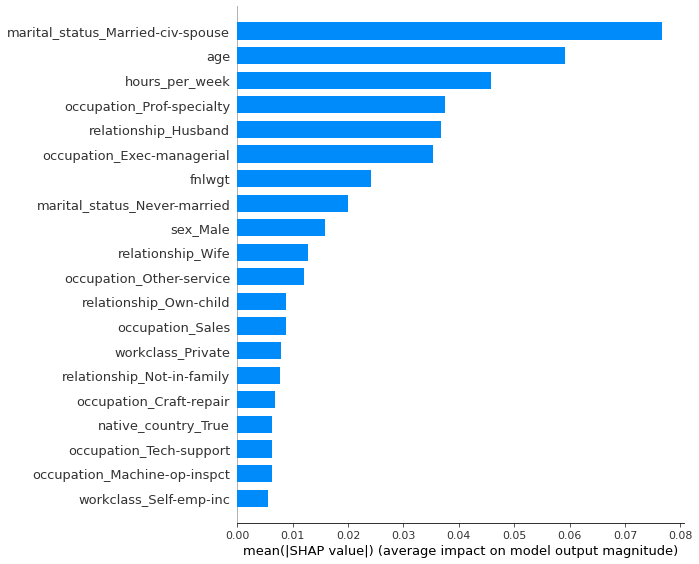

In [21]:
shap.summary_plot(train_rf_shap_values[1], X_train_enc, plot_type="bar")

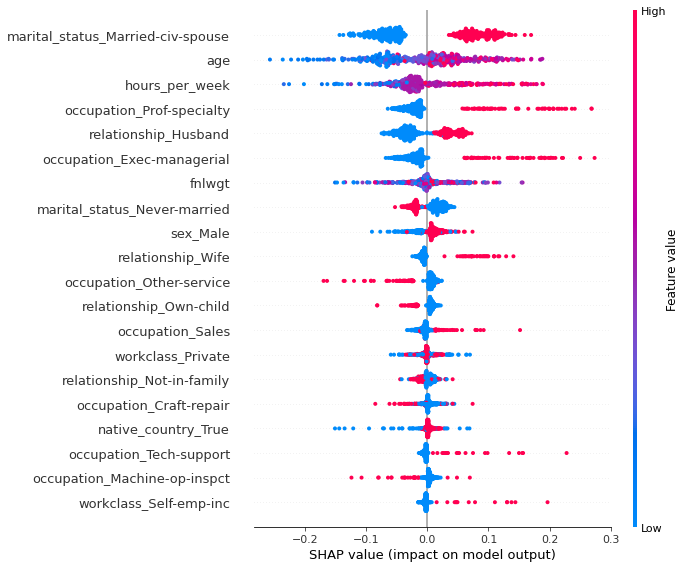

In [22]:
shap.summary_plot(train_rf_shap_values[1], X_train_enc[:500])

In [23]:
param_dist = {
    "randomforestclassifier__class_weight": [None, "balanced"],
    "randomforestclassifier__n_estimators": [10, 20, 50, 100, 200, 500],
    "randomforestclassifier__max_depth": np.arange(10, 20, 2)
}
rand_search_rf = RandomizedSearchCV(pipe_forest, param_dist, n_iter=20, 
                                    random_state=952, scoring=scoring, refit="f1")

rand_search_rf.fit(X_train, y_train);

In [24]:
hyperparam_result = pd.DataFrame(
    rand_search_rf.cv_results_
).sort_values("rank_test_f1")[['param_randomforestclassifier__n_estimators',
                                     'param_randomforestclassifier__max_depth',
                                     'param_randomforestclassifier__class_weight',
                                     'mean_test_accuracy',
                                     'mean_test_precision',
                                     'mean_test_recall',
                                     'mean_test_f1',
                                    ]]
hyperparam_result

,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__class_weight,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
10,200,16,balanced,0.796075,0.554746,0.776558,0.647130
16,100,18,balanced,0.801327,0.566443,0.745822,0.643855
18,20,16,balanced,0.788489,0.542265,0.781278,0.640177
7,10,18,balanced,0.792820,0.550996,0.754876,0.636973
3,200,12,balanced,0.770400,0.514475,0.828082,0.634640
6,20,12,balanced,0.768865,0.512401,0.831014,0.633879
11,50,12,balanced,0.768435,0.511818,0.831270,0.633528
14,50,10,balanced,0.754062,0.493813,0.848488,0.624287
15,500,18,None,0.829950,0.686959,0.540109,0.604704
1,50,18,None,0.828261,0.680775,0.540493,0.602530


In [25]:
# Evaluate Model with test data set
y_pred_train = rand_search_rf.predict(X_train)
y_pred = rand_search_rf.predict(X_test)

In [26]:
# Table of Metrics for positive class for train and test set
model_perf_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)],
        "Precision": [precision_score(y_train, y_pred_train), precision_score(y_test, y_pred)],
        "Recall": [recall_score(y_train, y_pred_train), recall_score(y_test, y_pred)],
        "F1 Score": [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred)]
    },
    index=["Train Data", "Test Data"])
model_perf_df

,Accuracy,Precision,Recall,F1 Score
Train Data,0.851571,0.629588,0.931896,0.751478
Test Data,0.792887,0.542718,0.782891,0.641047


In [27]:
# Confusion Matrix for the test set

test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, cross_val_predict(pipe_forest, X_test, y_test)),
            columns = ['Predicted negative (0)', 'Predicted positive (1)'],
            index = ['True negative (0)', 'True positive (1)'])
test_confusion_matrix

,Predicted negative (0),Predicted positive (1)
True negative (0),11203,1232
True positive (1),1849,1997


In [28]:
# Classification report for test set

pipe_forest.fit(X_train, y_train)

y_pred = pipe_forest.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["negative (0)", "positive (1)"], output_dict=True)
classification_report = pd.DataFrame(report).transpose()

In [29]:
# Table of Metrics for train set

PR_curve_df = pd.DataFrame(precision_recall_curve(y_train, rand_search_rf.predict_proba(X_train)[:,1],), index=["precision","recall","threshold"]).T
PR_curve_df['F1 Score'] =  2 * (PR_curve_df['precision'] * PR_curve_df['recall'])/(PR_curve_df['precision'] + PR_curve_df['recall'])
PR_curve_df

,precision,recall,threshold,F1 Score
0,0.424871,1.000000,0.143969,0.596364
1,0.424840,0.999872,0.143974,0.596311
2,0.424863,0.999872,0.144014,0.596334
3,0.424886,0.999872,0.144134,0.596356
4,0.424909,0.999872,0.144137,0.596379
...,...,...,...,...
18009,1.000000,0.000510,0.968977,0.001020
18010,1.000000,0.000383,0.969254,0.000765
18011,1.000000,0.000255,0.971625,0.000510
18012,1.000000,0.000128,0.971725,0.000255


In [30]:
# Average precision score for test set

ap_forest = average_precision_score(y_test, pipe_forest.predict_proba(X_test)[:, 1])
print("Average precision of Random Forest Classifier: {:.3f}".format(ap_forest))

Average precision of Random Forest Classifier: 0.614


In [31]:
# Threshold to get best F1 score
max_f1_df = PR_curve_df.iloc[PR_curve_df["F1 Score"].idxmax()].to_frame().T
best_thres = max_f1_df['threshold'].iloc[0]
max_f1_df

,precision,recall,threshold,F1 Score
7784,0.660985,0.890193,0.551693,0.758654


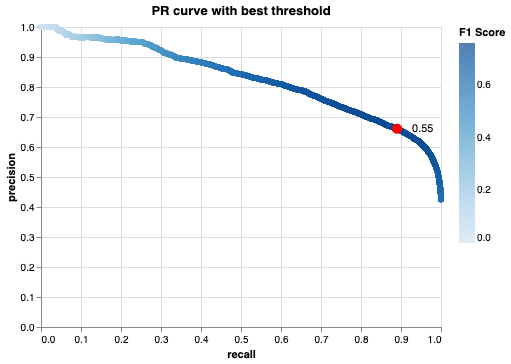

In [32]:
# PR curve with best threshold

PR_curve = alt.Chart(PR_curve_df).mark_circle().encode(
    x="recall",
    y="precision",
    color="F1 Score"
)
max_f1_point = alt.Chart(max_f1_df, 
                         title = 'PR curve with best threshold',).mark_circle(
    color="red", size=100, opacity=1).encode(
    x="recall",
    y="precision"
)

text = max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("threshold", format = ".2f"))

PR_curve_plot = PR_curve + max_f1_point + text
PR_curve_plot

In [33]:
# Evaluate Model with test data set with best_thres
y_pred_train_thres = rand_search_rf.predict_proba(X_train)[:, 1] > best_thres
y_pred_thres = rand_search_rf.predict_proba(X_test)[:, 1] > best_thres

In [34]:
# Table of Metrics for positive class with best_thres
model_perf_thres_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_pred_train_thres), accuracy_score(y_test, y_pred_thres)],
        "Precision": [precision_score(y_train, y_pred_train_thres), precision_score(y_test, y_pred_thres)],
        "Recall": [recall_score(y_train, y_pred_train_thres), recall_score(y_test, y_pred_thres)],
        "F1 Score": [f1_score(y_train, y_pred_train_thres), f1_score(y_test, y_pred_thres)]
    },
    index=["Train Data w/ best threshold", "Test Data w/ best threshold"])

In [35]:
model_perf_best_thres_df = pd.concat([model_perf_df, model_perf_thres_df])
model_perf_best_thres_df

,Accuracy,Precision,Recall,F1 Score
Train Data,0.851571,0.629588,0.931896,0.751478
Test Data,0.792887,0.542718,0.782891,0.641047
Train Data w/ best threshold,0.863579,0.660953,0.890065,0.758587
Test Data w/ best threshold,0.805172,0.567752,0.734269,0.640363


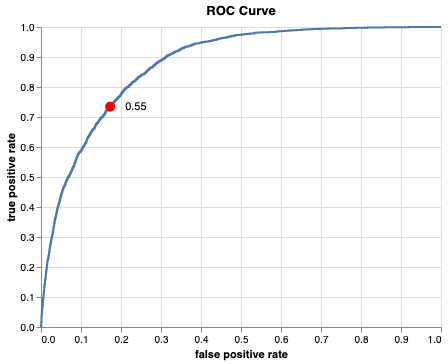

In [36]:
# # ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['thresholds'] = thresholds

pt_roc_idx = (roc_df['thresholds'] - best_thres).abs().argmin()

roc_curves = alt.Chart(roc_df, title = "ROC Curve").mark_line().encode(
        alt.X('fpr', title="false positive rate"),
        alt.Y('tpr', title="true positive rate"))

roc_max_f1_point = alt.Chart(pd.DataFrame(roc_df.iloc[pt_roc_idx]).T, 
                         ).mark_circle(
    color="red", size=100, opacity=1).encode(
    x="fpr",
    y="tpr"
)

roc_text = roc_max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("thresholds:Q", format = ".2f"))

roc_curve_plot = roc_curves + roc_max_f1_point + roc_text
roc_curve_plot

In [37]:
# ROC_AUC and AP score

ap_forest = average_precision_score(y_test, rand_search_rf.predict_proba(X_test)[:, 1])
roc_forest = roc_auc_score(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

test_model_perf_df = pd.DataFrame({
    "Accuracy" : model_perf_thres_df.loc["Test Data w/ best threshold"]["Accuracy"],
    "Precision" : model_perf_thres_df.loc["Test Data w/ best threshold"]["Precision"],
    "Recall" : model_perf_thres_df.loc["Test Data w/ best threshold"]["Recall"],
    "F1 Score" : model_perf_thres_df.loc["Test Data w/ best threshold"]["F1 Score"],
    "Average Precision Score" : ap_forest,
    "AUC Score" : roc_forest},
    index = ["Test Data Metrics"]).T
test_model_perf_df

,Test Data Metrics
Accuracy,0.805172
Precision,0.567752
Recall,0.734269
F1 Score,0.640363
Average Precision Score,0.669854
AUC Score,0.877095
